

# Procesamiento de lenguaje natural
## LSTM Bot QA

### Datos
El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [2]:
import re

import numpy as np
import pandas as pd

import tensorflow as tf
from keras.preprocessing.text import one_hot
from tensorflow.keras.utils import pad_sequences, plot_model
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SimpleRNN
from keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input

In [3]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download
To: /content/data_volunteers.json
100%|██████████| 2.58M/2.58M [00:00<00:00, 115MB/s]


In [4]:
# dataset_file
import json

text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f) # la variable data será un diccionario

In [5]:
# Observar los campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [6]:
chat_in = []
chat_out = []

input_sentences = [] # array de texto de entrada
output_sentences = [] # array de texto de salida del decoder
output_sentences_inputs = [] # array de texto de entrada al decoder
max_len = 30

def clean_text(txt):
    txt = txt.lower()
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)

    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        # vamos separando el texto en "preguntas" (chat_in)
        # y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out

        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>' # salida del decoder
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output # entrada del decoder

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 6033


In [7]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

### 2 - Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

In [8]:
# Definir el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 8000

In [9]:
# Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# - num_words --> the maximum number of words to keep, based on word frequency.
# - Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer

# tokenizador de inglés
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)
print(input_integer_seq[1])

[11, 10, 7, 2]


In [10]:
word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_inputs))

Palabras en el vocabulario: 1799


In [11]:
print(word2idx_inputs)

{'i': 1, 'you': 2, 'do': 3, 'what': 4, 'a': 5, 'to': 6, 'are': 7, 'for': 8, 'am': 9, 'how': 10, 'hi': 11, 'like': 12, 'living': 13, 'love': 14, 'is': 15, 'have': 16, 'm': 17, 'that': 18, 'hello': 19, 'oh': 20, 'your': 21, 'ok': 22, 'read': 23, 'good': 24, 'yes': 25, 'the': 26, 'it': 27, 'not': 28, 'no': 29, 's': 30, 'any': 31, 'work': 32, 'in': 33, 'u': 34, 'me': 35, 'my': 36, 'about': 37, 'and': 38, 'from': 39, 't': 40, 'of': 41, 'go': 42, 'play': 43, 'today': 44, 'too': 45, 'so': 46, 'don': 47, 'hobbies': 48, 'nice': 49, 'fine': 50, 'name': 51, 'where': 52, 'cool': 53, 'doing': 54, 'there': 55, 'hey': 56, 'know': 57, 'bye': 58, 'see': 59, 'great': 60, 'well': 61, 'favorite': 62, 'sure': 63, 'old': 64, 'games': 65, 'pets': 66, 'why': 67, 'beach': 68, 'sorry': 69, 'at': 70, 'nothing': 71, 'mean': 72, 'lot': 73, 'fun': 74, 'live': 75, 'okay': 76, 'thanks': 77, 'also': 78, 'can': 79, 'student': 80, 'city': 81, 'vegan': 82, 'video': 83, 'girl': 84, 'with': 85, 'yeah': 86, 'just': 87, 'wow

In [12]:
max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

Sentencia de entrada más larga: 9


In [13]:
# tokenizamos los outputs
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

In [14]:
word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_outputs))

Palabras en el vocabulario: 1806


In [15]:
print(word2idx_outputs)

{'eos': 1, 'you': 2, 'i': 3, 'do': 4, 'what': 5, 'a': 6, 'are': 7, 'to': 8, 'for': 9, 'how': 10, 'am': 11, 'living': 12, 'like': 13, 'love': 14, 'have': 15, 'is': 16, 'm': 17, 'your': 18, 'read': 19, 'hello': 20, 'oh': 21, 'good': 22, 'that': 23, 'hi': 24, 'it': 25, 'the': 26, 'any': 27, 'not': 28, 'yes': 29, 'u': 30, 'and': 31, 'work': 32, 'about': 33, 'me': 34, 's': 35, 'in': 36, 'no': 37, 'my': 38, 'ok': 39, 'fine': 40, 'from': 41, 'today': 42, 'of': 43, 'hobbies': 44, 'doing': 45, 't': 46, 'where': 47, 'name': 48, 'play': 49, 'too': 50, 'go': 51, 'so': 52, 'well': 53, 'see': 54, 'great': 55, 'don': 56, 'favorite': 57, 'bye': 58, 'pets': 59, 'nice': 60, 'know': 61, 'there': 62, 'at': 63, 'hey': 64, 'why': 65, 'can': 66, 'sure': 67, 'live': 68, 'cool': 69, 'fun': 70, 'thanks': 71, 'old': 72, 'games': 73, 'beach': 74, 'job': 75, 'tell': 76, 'with': 77, 'student': 78, 'mean': 79, 'sorry': 80, 'girl': 81, 'up': 82, 'video': 83, 'vegan': 84, 'day': 85, 'city': 86, 'nothing': 87, 'cook': 

In [16]:
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

Sentencia de salida más larga: 10


In [17]:
# Se suma 1 para incluir el token de palabra desconocida
num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE)
print(num_words_output)

1807


In [18]:
# a la hora de realiza padding es importante tener en cuenta que en el encoder
# los ceros se agregan al comienzo y en el decoder al final. Esto es porque
# la salida del encoder está basado en las últimas palabras de la sentencia
# (son las más importantes), mientras que en el decoder está basado
# en el comienzo de la secuencia de salida ya que es la realimentación del sistema
# y termina con fin de sentencia.

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

encoder_input_sequences shape: (6033, 9)
decoder_input_sequences shape: (6033, 10)


In [19]:
#Se utiliza "decoder_output_sequences" con la misma estrategia con que se transformó la entrada del decoder.
from keras.utils import to_categorical
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output) # pasamos a OnehotEncoding
print("decoder_targets: ")
print(f"cantidad de datapoints {decoder_targets.shape[0]}, tamaño de secuencia {decoder_targets.shape[1]}, tamaño de vocabulario {decoder_targets.shape[2]}")

decoder_targets: 
cantidad de datapoints 6033, tamaño de secuencia 10, tamaño de vocabulario 1807


### 3 - Preparar los embeddings
Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores

In [20]:
# siguiendo recomendación descargamos FastText
import os
import gdown
!curl -L -o 'fasttext.pkl' 'https://drive.google.com/u/0/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa&export=download&confirm=t'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 2746M  100 2746M    0     0  90.7M      0  0:00:30  0:00:30 --:--:--  107M


In [21]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60


class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [22]:
model_embeddings = FasttextEmbeddings()

In [23]:
# Crear la Embedding matrix de las secuencias del encoder
print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:

        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 1


In [24]:
# Dimensión de los embeddings
embedding_matrix.shape

(1799, 300)

In [25]:
# Crear la Embedding matrix de las secuencias del decoder
# nb_words para el decoder
print('preparing embedding matrix...')
embed_dim_2 = model_embeddings.N_FEATURES
words_not_found_2 = []


nb_words_deco = min(MAX_VOCAB_SIZE, num_words_output) # vocab_size
embedding_matrix_2 = np.zeros((nb_words_deco, embed_dim_2))
for word, i in word2idx_outputs.items():
    if i >= nb_words_deco:
        continue
    embedding_vector_2 = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector_2 is not None) and len(embedding_vector_2) > 0:

        embedding_matrix_2[i] = embedding_vector_2
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found_2.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix_2**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 1


In [26]:
# Dimensión de los embeddings
embedding_matrix_2.shape

(1807, 300)

### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

In [27]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense

n_units = 128

# define training encoder
encoder_inputs = Input(shape=(max_input_len))

# embedding preentrenado para la entrada del encoder
encoder_embedding_layer = Embedding(
          input_dim=nb_words,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=max_input_len, # tamaño máximo de la secuencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)      # marcar como layer no entrenable

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder = LSTM(n_units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# define training decoder

# embedding preentrenado para la entrada del decoder
decoder_embedding_layer = Embedding(
          input_dim=nb_words_deco,  # definido en el Tokenizador
          output_dim=embed_dim_2,  # dimensión de los embeddings utilizados
          input_length=max_out_len, # tamaño máximo de la secuencia de entrada
          weights=[embedding_matrix_2],  # matrix de embeddings
          trainable=False)      # marcar como layer no entrenable

decoder_inputs = Input(shape=(max_out_len))
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Dense
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 9)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 10)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 9, 300)               539700    ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 10, 300)              542100    ['input_2[0][0]']             
                                                                                              

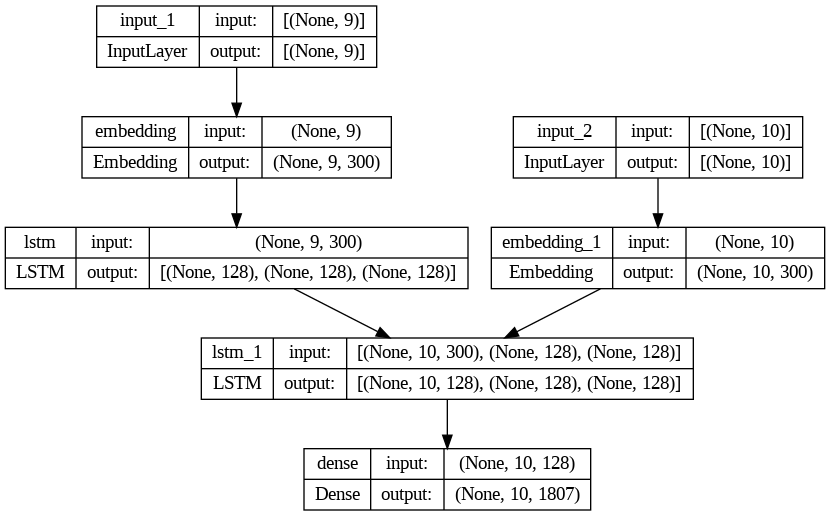

In [28]:
# Modelo completo (encoder+decoder) para poder entrenar
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [29]:
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=30,
    validation_split=0.2)

Epoch 1/30
151/151 [==============================] - 13s 18ms/step - loss: 2.9788 - accuracy: 0.5389 - val_loss: 2.2607 - val_accuracy: 0.6310
Epoch 2/30
151/151 [==============================] - 2s 11ms/step - loss: 2.0062 - accuracy: 0.6486 - val_loss: 2.0465 - val_accuracy: 0.6650
Epoch 3/30
151/151 [==============================] - 2s 14ms/step - loss: 1.7891 - accuracy: 0.6875 - val_loss: 1.9441 - val_accuracy: 0.6770
Epoch 4/30
151/151 [==============================] - 2s 12ms/step - loss: 1.6738 - accuracy: 0.7008 - val_loss: 1.8843 - val_accuracy: 0.6872
Epoch 5/30
151/151 [==============================] - 2s 12ms/step - loss: 1.5985 - accuracy: 0.7094 - val_loss: 1.8497 - val_accuracy: 0.6900
Epoch 6/30
151/151 [==============================] - 2s 11ms/step - loss: 1.5402 - accuracy: 0.7171 - val_loss: 1.8230 - val_accuracy: 0.6951
Epoch 7/30
151/151 [==============================] - 2s 10ms/step - loss: 1.4953 - accuracy: 0.7224 - val_loss: 1.8037 - val_accuracy: 0.697

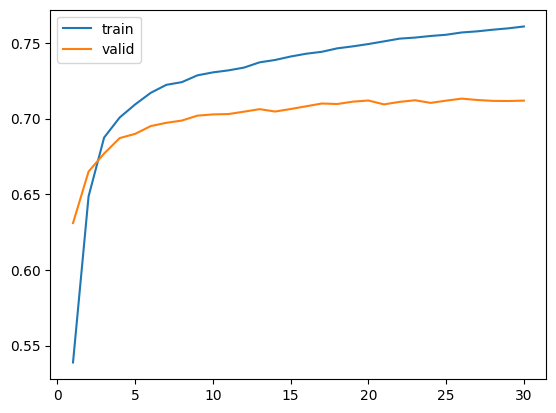

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

**obs**

Se muestra un claro overfitting en el entrenamiento, pero la diferencia entre el set de entrenamiento y validación es aceptable. El accuracy aproxima en ambos casos al 70%.

### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

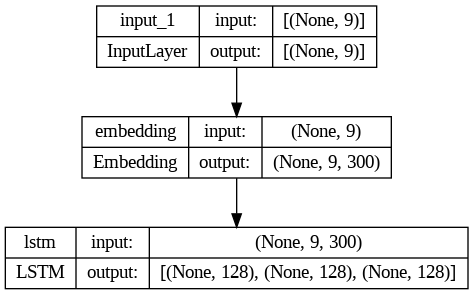

In [31]:
# Modelo solo encoder

# define inference encoder
encoder_model = Model(encoder_inputs, encoder_states)

plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

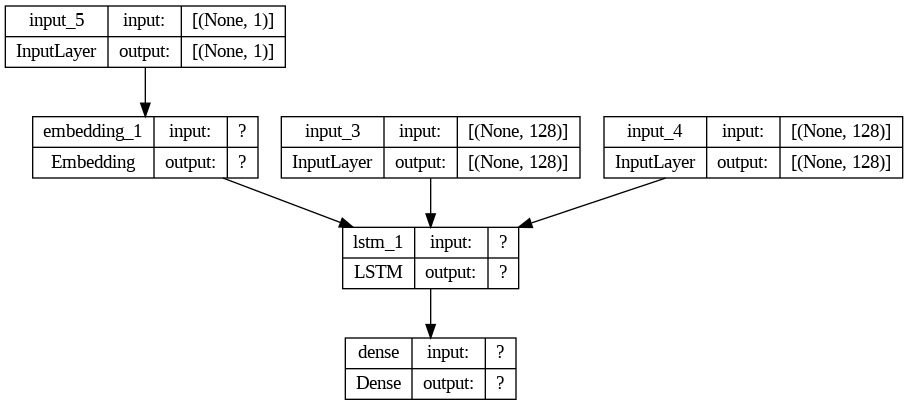

In [32]:
# Modelo solo decoder (para realizar inferencia)

# define inference decoder
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# En cada predicción habrá una sola palabra de entrada al decoder,
# que es la realimentación de la palabra anterior
# por lo que hay que modificar el input shape de la layer de Embedding
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

In [33]:
# Armar los conversores de índice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [34]:
word2idx_outputs['eos']

1

In [35]:
def chatbot_response(input_seq):
    # Se transforma la sequencia de entrada a los estados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder
    states_value = encoder_model.predict(input_seq)

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['sos']

    # Se obtiene el índice que finaliza la inferencia
    eos = word2idx_outputs['eos']

    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar idx a palabra
        word = ''
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dada la última predicción
        states_value = [h, c]

        # Actualizar secuencia de entrada con la salida (re-alimentación)
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

In [36]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
output_seq = chatbot_response(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', output_seq)

1/1 [==============================] - 0s 35ms/step
-
Input: new
Response: what do you do for a living


In [37]:
while True:
    # pedir input al usuario
    message = input("")
    integer_seq_test = input_tokenizer.texts_to_sequences([message])[0]
    encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
    output_seq = chatbot_response(encoder_sequence_test)

    print("Q:", message)
    if message == 'q':
      print("bye bye :)")
      break
    print('Response:', output_seq)

hi there
1/1 [==============================] - 0s 18ms/step
Q: hi there
Response: hello how are you today
fine thank you
1/1 [==============================] - 0s 20ms/step
Q: fine thank you
Response: what do you do for a living
i study
1/1 [==============================] - 0s 21ms/step
Q: i study
Response: what do you do for a living
I work at papershop
1/1 [==============================] - 0s 19ms/step
Q: I work at papershop
Response: what do you do for a living
Do you read?
1/1 [==============================] - 0s 21ms/step
Q: Do you read?
Response: i like to read
Do you have any pet?
1/1 [==============================] - 0s 22ms/step
Q: Do you have any pet?
Response: i am a girl
Where are you from?
1/1 [==============================] - 0s 23ms/step
Q: Where are you from?
Response: i am a student
What do you do?
1/1 [==============================] - 0s 20ms/step
Q: What do you do?
Response: i am a student
Well, I love video games. What about you?
1/1 [========================

### Armamos respuestas con beam search

In [38]:
def chatbot_response_beam_search(input_seq, beam_width=3):
    # Obtener los estados iniciales del codificador
    states_value = encoder_model.predict(input_seq)

    # Inicializar la secuencia de entrada del decodificador como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['sos']

    # Obtener el índice que indica el final de la inferencia
    eos = word2idx_outputs['eos']

    # Inicializar la lista de secuencias candidatas con puntaje
    candidate_sequences = [([], 1.0)]

    while True:
        # Almacenar las nuevas secuencias candidatas
        new_candidates = []

        for seq, score in candidate_sequences:
            # Predecir el próximo elemento para la secuencia actual
            output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

            # Obtener las primeras 'beam_width' palabras más probables
            top_k_indices = np.argpartition(output_tokens[0, 0, :], -beam_width)[-beam_width:]

            for idx in top_k_indices:
                # Si la palabra predicha es "<eos>", la agregamos a las candidatas y seguimos
                if idx == eos:
                    new_seq = seq + [idx]
                    new_candidates.append((new_seq, score))
                    continue

                # Calcular el nuevo puntaje
                new_score = score * output_tokens[0, 0, idx]

                # Actualizar los estados y la secuencia de entrada para la siguiente iteración
                new_states_value = [h, c]
                new_target_seq = np.zeros((1, 1))
                new_target_seq[0, 0] = idx

                # Agregar la nueva secuencia candidata a la lista
                new_seq = seq + [idx]
                new_candidates.append((new_seq, new_score))

        # Ordenar las secuencias candidatas por puntaje
        candidate_sequences = sorted(new_candidates, key=lambda x: x[1], reverse=True)[:beam_width]

        # Actualizar estados y secuencia de entrada para la siguiente iteración
        states_value = new_states_value
        target_seq[0, 0] = candidate_sequences[0][0][-1]  # Tomar la última palabra de la mejor secuencia

        # Verificar si todas las secuencias candidatas terminan con "<eos>"
        if all(seq[-1] == eos for seq, _ in candidate_sequences):
            break

    # Retornar la mejor secuencia generada (la primera en la lista)
    best_sequence = candidate_sequences[0][0]
    output_sentence = [idx2word_target[idx] for idx in best_sequence if idx != eos]

    return ' '.join(output_sentence)

In [39]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
output_seq = chatbot_response_beam_search(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', output_seq)

1/1 [==============================] - 0s 23ms/step
-
Input: pizza
Response: i love to read


In [40]:
while True:
    # pedir input al usuario
    message = input("")
    integer_seq_test = input_tokenizer.texts_to_sequences([message])[0]
    encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
    output_seq = chatbot_response_beam_search(encoder_sequence_test)

    print("Q:", message)
    if message == 'q':
      print("bye bye :)")
      break
    print('Response:', output_seq)

hi there
1/1 [==============================] - 0s 24ms/step
Q: hi there
Response: hello
what do you do for a living?
1/1 [==============================] - 0s 24ms/step
Q: what do you do for a living?
Response: i am a student
Do you read?
1/1 [==============================] - 0s 21ms/step
Q: Do you read?
Response: i like to read
Do you have any pet?
1/1 [==============================] - 0s 21ms/step
Q: Do you have any pet?
Response: i am a girl
Where are you from?
1/1 [==============================] - 0s 22ms/step
Q: Where are you from?
Response: i am a student
I have a cat named charlie. What about you?
1/1 [==============================] - 0s 47ms/step
Q: I have a cat named charlie. What about you?
Response: 
I have a cat named charlie. What about you?
1/1 [==============================] - 0s 30ms/step
Q: I have a cat named charlie. What about you?
Response: 
Do you have a cat?
1/1 [==============================] - 0s 20ms/step
Q: Do you have a cat?
Response: i am a girl
Do yo

**Analisis**

El bot QA que se construyó a partir de la arquitectura encoder-decoder con seq2seq, usando una LSTM y embeddings preentrenados con FastText. Con esto, se puede decir que el modelo tuvo un rendimiento aceptable con un accuracy de 70%.

Entre las pruebas que se realizaron se utilizarón dos formas de buscar las mejores respuestas, entre ellas se utilizó greedy search y beam search.

Con ambos algoritmos se obtuvieron similitudes en las respuestas del bot. Ejemplo:

Greedy Search:

Q: Do you read?

Response: i like to read

o

Q: hi there

Response: hello how are you today

Beam Search:

Q: Do you read?

Response: i like to read

o

Q: hi there

Response: hello

Con el overfitting que se obtuvo durante el entrenamiento y el accuracy de 70%, fueron los causantes del error que se puede apreciar en las respuestas dadas por el bot.